In [50]:
from db import DB
db = DB()

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('fivethirtyeight') # fivethirtyeight, fast
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] # font to handle chinese
%matplotlib inline

In [51]:
#####################
### prepare data 
#####################
import pandas as pd
from talib import abstract
import utility as util

def prepare_stock_data(db):
    stock_data = {}
    for stock_id in db.get_stock_info().index:
        df_daily = db.get_daily_price(stock_id)
        df_monthly = db.get_by_stock_id(stock_id, 'monthly_revenue')
        df_quarterly = db.get_by_stock_id(stock_id, 'quarterly_report')
        
        ### fundamental
        def compared_ratio(s, num):
            return s / s.shift(num) - 1
        def compared_diff(s, num):
            return s - s.shift(num)
        
        df_monthly['3月營收'] = df_monthly.當月營收.rolling(3).mean()
        df_monthly['12月營收'] = df_monthly.當月營收.rolling(12).mean()
        df_monthly['當月營收_年增率'] = compared_ratio(df_monthly['當月營收'], 12)
        df_monthly['3月營收_年增率'] = compared_ratio(df_monthly['3月營收'], 12)
        df_monthly['12月營收_年增率'] = compared_ratio(df_monthly['12月營收'], 12)
        util.fill_short_interval_by_long_interval(df_daily, df_monthly, '當月營收_年增率')
        util.fill_short_interval_by_long_interval(df_daily, df_monthly, '3月營收_年增率')
        util.fill_short_interval_by_long_interval(df_daily, df_monthly, '12月營收_年增率')
        
        df_quarterly['毛利率'] = df_quarterly.毛利 / df_quarterly.營收
        df_quarterly['營益率'] = df_quarterly.營利 / df_quarterly.營收
        df_quarterly['淨利率'] = df_quarterly.稅後淨利 / df_quarterly.營收
        df_quarterly['毛利率_年增'] = compared_diff(df_quarterly['毛利率'], 4)
        df_quarterly['營益率_年增'] = compared_diff(df_quarterly['營益率'], 4)
        df_quarterly['淨利率_年增'] = compared_diff(df_quarterly['淨利率'], 4)
        util.fill_short_interval_by_long_interval(df_daily, df_quarterly, '毛利率_年增')
        util.fill_short_interval_by_long_interval(df_daily, df_quarterly, '營益率_年增')
        util.fill_short_interval_by_long_interval(df_daily, df_quarterly, '淨利率_年增')
    
        df_quarterly['EPS4季'] = df_quarterly.EPS.rolling(4).sum()
        股數 = df_quarterly.股本 / 10
        df_quarterly['淨值/股'] = df_quarterly.權益 / 股數
        util.fill_short_interval_by_long_interval(df_daily, df_quarterly, 'EPS4季')
        util.fill_short_interval_by_long_interval(df_daily, df_quarterly, '淨值/股')
        
        df_daily['本益比'] = df_daily.close / df_daily.EPS4季
        df_daily['本淨比'] = df_daily.close / df_daily['淨值/股']
        df_daily['眼光費'] = (df_daily.close - df_daily['淨值/股']) / df_daily.EPS4季
        
        fundamental_cols = ['當月營收_年增率', '3月營收_年增率', '12月營收_年增率',
                            '毛利率_年增', '營益率_年增', '淨利率_年增',
                            'EPS4季', '淨值/股', '本益比', '本淨比', '眼光費']
        
        ### technical
        df_daily['close_5'] = df_daily.close.rolling(5).mean()
        df_daily['close_10'] = df_daily.close.rolling(10).mean()
        df_daily['close_20'] = df_daily.close.rolling(20).mean()
        df_daily['volume_5'] = df_daily.volume.rolling(5).mean()
        df_daily['volume_10'] = df_daily.volume.rolling(10).mean()
        MACD = abstract.MACD(df_daily)
        MACD.columns = ['DIFF', 'DEM', 'D-M']
        df_daily[['DIFF', 'DEM', 'D-M']] = MACD
        KD = abstract.STOCH(df_daily)
        KD.columns = ['K', 'D']
        df_daily[['K', 'D']] = KD
        
        technical_cols = ['close', 'close_5', 'close_10', 'close_20', 'volume', 'volume_5', 'volume_10', 
                          'DIFF', 'DEM', 'K', 'D']
        
        ### chip
        buy_surplus = db.get_by_stock_id(stock_id, 'daily_buy_sell_surplus')
        df_daily = pd.merge(df_daily, buy_surplus, left_index=True, right_index=True)
        df_daily['foreign_5'] = df_daily.foreign.rolling(5).mean()
        df_daily['foreign_10'] = df_daily.foreign.rolling(10).mean()
        
        chip_cols = ['foreign_5', 'foreign_10']
        
        stock_data[stock_id] = df_daily[fundamental_cols + technical_cols + chip_cols].dropna()

    return stock_data

stock_data = prepare_stock_data(db)

In [52]:
#####################
### label 
#####################
INTERVAL = 120
dfs = []
for stock_id in stock_data:
    df_daily = stock_data[stock_id].copy()
    df_daily['label'] = 0
    for i in range(len(df_daily.index) - INTERVAL):
        close = df_daily['close'].iloc[i]
        max_close = df_daily['close'].iloc[i : i + INTERVAL].max()
        min_close = df_daily['close'].iloc[i : i + INTERVAL].min()
        ### buy signal
        high_return = max_close / close - 1 > 0.3
        low_risk = min_close / close - 1 > -0.1
        if high_return & low_risk:
            df_daily['label'].iloc[i] = 1
        ### sell signal    
        high_return = min_close / close - 1 < -0.15
        low_risk = max_close / close - 1 < 0.1
        if high_return & low_risk:
            df_daily['label'].iloc[i] = -1
            
    dfs.append(df_daily.iloc[:-INTERVAL])
    
df_all = pd.concat(dfs)
df_all.to_csv('ml_data/data.csv', index=True, index_label='date')

c:\users\user\anaconda3\lib\site-packages\pandas\core\indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [53]:
#####################
### train
#####################
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import precision_score, recall_score, accuracy_score
def accuracy_score(s1, s2):
    result = []
    for label, predict in zip(s1, s2):
        if predict != 0:
            score = 1 if predict == label else 0
            result.append(score)
    return np.mean(result)
                
def build_and_train(X, y):
    ### build model
    model = RandomForestClassifier(n_estimators=30, max_depth=10, max_features='sqrt', random_state=7)
        
    ### split train & test data
    day_step = 120
    dates = sorted(list(set(X.index)))
    dates_length = len(dates)
    accuracy_train = []
    accuracy_test = []
    
    for i_start in range(day_step * 5, dates_length, day_step):
        i_end = i_start + day_step
        if i_end >= dates_length:
            i_end = dates_length - 1
        print('==============================')
        print('test data from', dates[i_start].date() , 'to', dates[i_end].date())
        X_train, X_test = (X.loc[dates[0] : dates[i_start]], X.loc[dates[i_start] : dates[i_end]])
        y_train, y_test = (np.ravel(y.loc[dates[0] : dates[i_start]]), np.ravel(y.loc[dates[i_start] : dates[i_end]]))

        ### train model
        model.fit(X_train, y_train)
    
        y_pred = model.predict(X_train)
        acc = accuracy_score(y_train, y_pred)
        accuracy_train.append(acc)
        print('Train Accuracy:', acc)

        ### predict
        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        accuracy_test.append(acc)
        print('Test Accuracy: ', acc)
    
    print('\nAverage Train Accuracy:', np.mean(accuracy_train))
    print('Average Test Accuracy:', np.mean(accuracy_test))
    return model

df = pd.read_csv('ml_data/data.csv', index_col=['date'], parse_dates=['date']).sort_index()
y = df[['label']]
X = df.drop(['label'], axis=1)

model = build_and_train(X, y)

test data from 2017-07-07 to 2017-12-27
Train Accuracy: 0.9802169751116784
Test Accuracy:  0.4731182795698925
test data from 2017-12-27 to 2018-07-02
Train Accuracy: 0.9784117193523516
Test Accuracy:  0.5411764705882353
test data from 2018-07-02 to 2018-12-19
Train Accuracy: 0.9830176355323318
Test Accuracy:  0.78
test data from 2018-12-19 to 2019-06-13
Train Accuracy: 0.9839610740673995
Test Accuracy:  0.3712121212121212

Average Train Accuracy: 0.9814018510159404
Average Test Accuracy: 0.5413767178425622


In [54]:
feature_importances = pd.Series(data=model.feature_importances_, index=X.columns).sort_values(ascending=False)
print(feature_importances)

12月營收_年增率     0.075471
EPS4季         0.070830
3月營收_年增率      0.068177
眼光費           0.065237
淨利率_年增        0.061249
本益比           0.059478
淨值/股          0.057913
close         0.056709
close_20      0.055930
本淨比           0.055889
當月營收_年增率      0.053358
毛利率_年增        0.053221
close_5       0.048087
close_10      0.043959
營益率_年增        0.042721
volume_10     0.035492
DEM           0.021126
DIFF          0.018921
volume_5      0.016825
foreign_10    0.012471
foreign_5     0.010477
volume        0.009217
D             0.003758
K             0.003484
dtype: float64


In [55]:
from sklearn.externals import joblib
### save model
# joblib.dump(model, 'ml_data/model.pkl')

### load model
# model = joblib.load('ml/data/model.pkl')

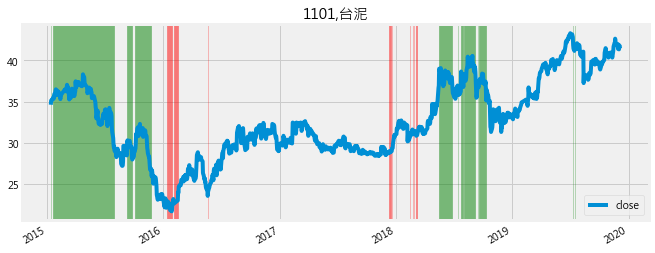

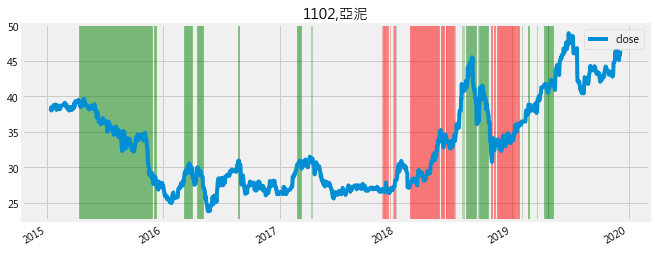

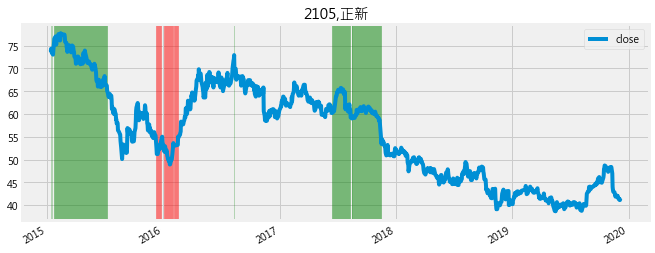

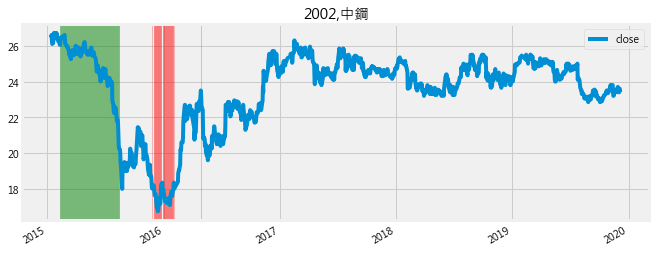

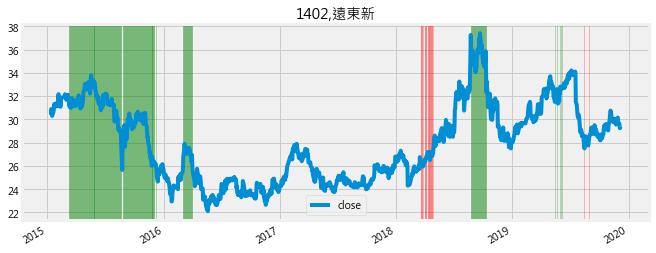

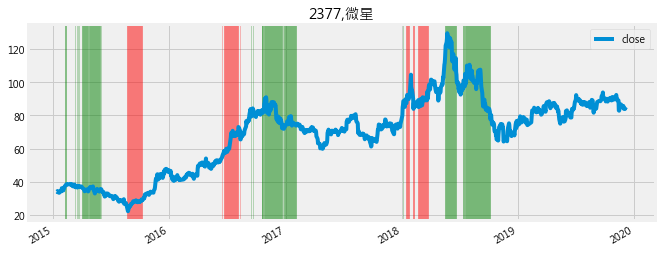

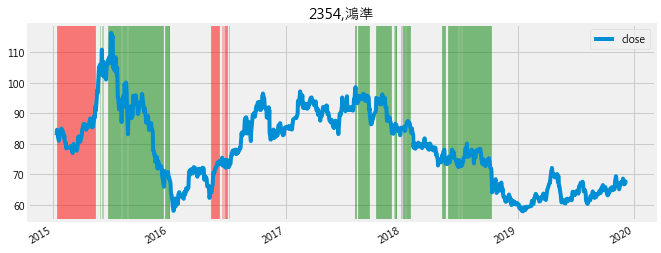

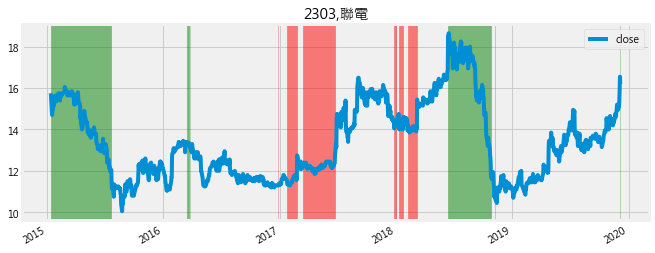

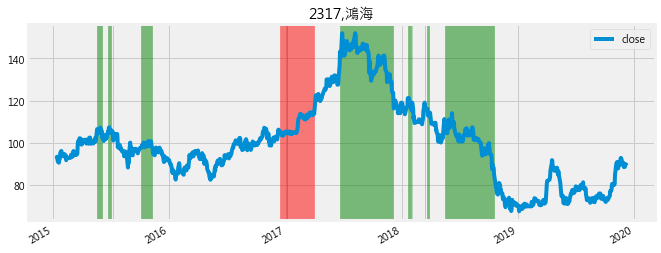

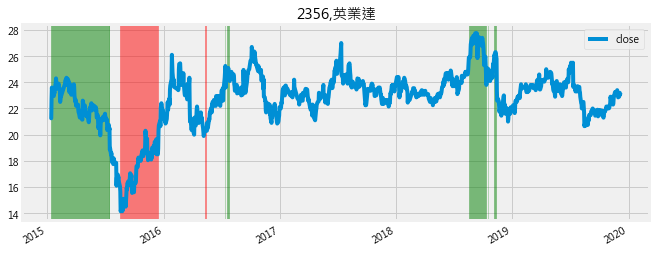

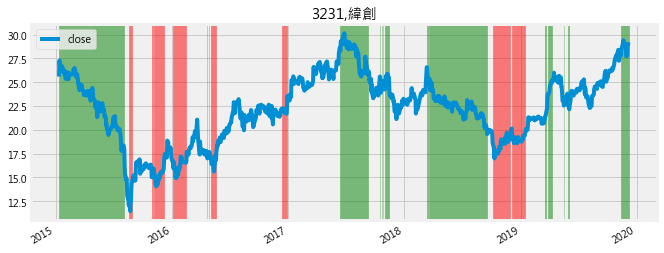

In [56]:
#####################
### predict & plot
#####################
def get_region(series, value):
    region = []
    get = False
    for i in range(len(series.index)):
        if series[i] == value:
            if not get:
                region.append([series.index[i]])
                get = True
            continue
        if get:
            region[-1].append(series.index[i - 1])
            get = False
    if len(region) > 0 and len(region[-1]) == 1:
        region[-1].append(series.index[-1])
    return region

def draw_region(region, ax, color):
    for xmin, xmax in region:
        ax.axvspan(xmin, xmax, color=color, alpha=0.5)
    
stock_info = db.get_stock_info()
for stock_id in stock_data:
    stock_name = stock_info.loc[stock_id, 'stock_name']
    df_daily_ori = stock_data[stock_id]
    df_daily = df_daily_ori.copy()
    ### predict
    df_daily['label'] = model.predict(df_daily_ori)
    ### plot
    region_buy = get_region(df_daily['label'], 1)
    if len(region_buy) > 0:
        ax = df_daily[['close']].plot(grid=True, title=stock_id + ',' + stock_name, figsize=(10,4))
        draw_region(region_buy, ax, 'red')
        region_sell = get_region(df_daily['label'], -1)
        draw_region(region_sell, ax, 'green')